# 1. Import Dependencies and Data

In [1]:
!pip install tensorflow tensorflow-gpu matplotlib tensorflow-datasets ipywidgets

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.8.6
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.3.1
altair                           4.2.2
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.5.0
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.0
attrs                            23.1.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.13.1
backcall                         0.2.0
beautifulsoup4                   4.11.2
bidict                           0.22.1
b

In [3]:
#Managing RAM utilization
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,True)

In [4]:
for gpu in gpus:
  print

In [5]:
#Bringing in tensorflow datasets for fashion mnist
import tensorflow_datasets as tfds
#Brining in matplotlib for viz stuff
import matplotlib.pyplot as plt

In [6]:
#Use tensorflow datasets api to bring in the data source
ds = tfds.load('fashion_mnist',split='train')

In [7]:
ds.as_numpy_iterator().next()['label']

2

# 2. Viz Data and Build Dataset

In [8]:
# Do some data transformation
import numpy as np

In [9]:
#Setup connection aka iterator
dataiterator = ds.as_numpy_iterator()

In [10]:
dataiterator.next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

In [11]:
np.squeeze(dataiterator.next()['image']).shape

(28, 28)

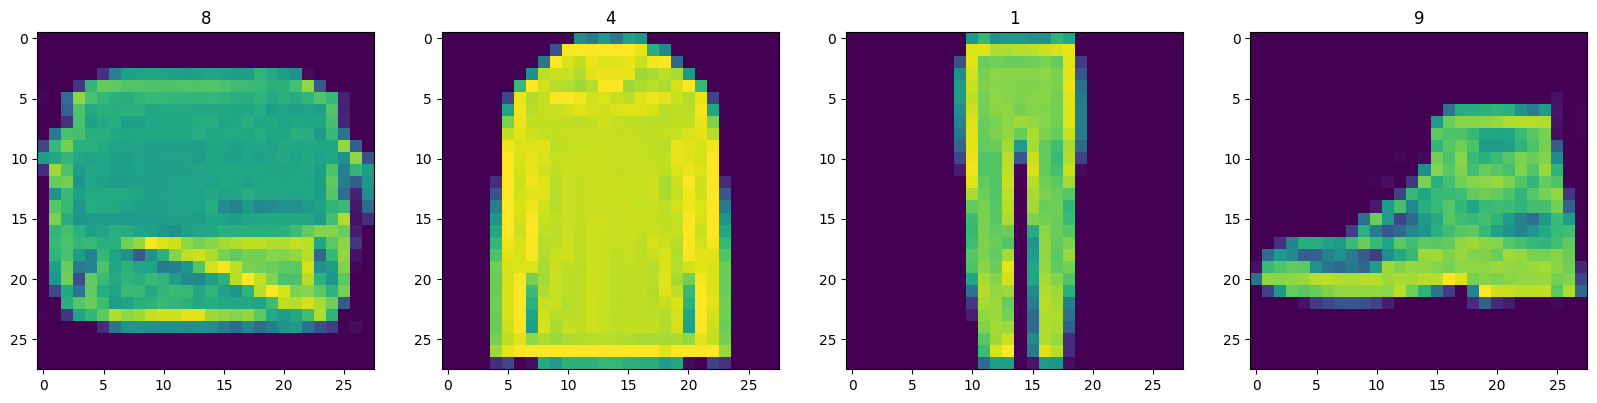

In [12]:
# Setup the subplot formatting
fig,ax = plt.subplots(ncols=4,figsize=(20,20))
# Loop four times and get images
for idx in range(4):
  # Grab an image and label
  sample = dataiterator.next()
  # Plot the image using a specific subplot
  ax[idx].imshow(np.squeeze(sample['image']))
  # Appending the image label as plot title
  ax[idx].title.set_text(sample['label'])

In [13]:
# Scale and return images only
def scale_images(data):
  image = data['image']
  return image / 255

In [14]:
# Reload the dataset
ds = tfds.load('fashion_mnist',split='train')
# Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images)
# Cache the dataset for that batch
ds = ds.cache()
# Shuffle it up
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking
ds = ds.prefetch(64)

In [15]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

# 3. Build Neural Network

### 3.1 Import Modelling Components

In [16]:
# Bring in the sequential api for the generator and discrimator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D , Dense , Flatten , Reshape , LeakyReLU , Dropout , UpSampling2D

### 3.2 Build Generator

In [17]:
def build_generator():
  model = Sequential()

  # Takes in random values and reshapes it to 7x7x128
  # Beginnings of generated image
  model.add(Dense(7*7*128, input_dim=128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7,7,128)))

  # Upsampling block 1
  model.add(UpSampling2D())
  model.add(Conv2D(128,5,padding='same'))
  model.add(LeakyReLU(0.2))

  # Upsampling block 2
  model.add(UpSampling2D())
  model.add(Conv2D(128,5,padding='same'))
  model.add(LeakyReLU(0.2))

  # Convolutional block 1
  model.add(Conv2D(128,4,padding='same'))
  model.add(LeakyReLU(0.2))

  # Convolutional block 2
  model.add(Conv2D(128,4,padding='same'))
  model.add(LeakyReLU(0.2))

  # Conv Layer to get to one channel
  model.add(Conv2D(1,4,padding='same',activation='sigmoid'))


  return model

In [18]:
generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [19]:
img = generator.predict(np.random.randn(4,128,1))
img

1/1 [==============================] - 2s 2s/step


array([[[[0.49436012],
         [0.50053936],
         [0.49693426],
         ...,
         [0.50085396],
         [0.4995194 ],
         [0.49900866]],

        [[0.49559233],
         [0.49467462],
         [0.5014165 ],
         ...,
         [0.49851698],
         [0.4985149 ],
         [0.5017827 ]],

        [[0.49129158],
         [0.4916104 ],
         [0.49098274],
         ...,
         [0.50731486],
         [0.4986413 ],
         [0.49977148]],

        ...,

        [[0.50318056],
         [0.5029196 ],
         [0.5043411 ],
         ...,
         [0.50152016],
         [0.50736684],
         [0.5031049 ]],

        [[0.5061962 ],
         [0.50405383],
         [0.5009667 ],
         ...,
         [0.5012353 ],
         [0.5030559 ],
         [0.5024901 ]],

        [[0.50496054],
         [0.5076941 ],
         [0.5102498 ],
         ...,
         [0.5022821 ],
         [0.50337607],
         [0.5015235 ]]],


       [[[0.50158703],
         [0.50154537],
         [0.50

In [20]:
img.shape

(4, 28, 28, 1)

1/1 [==============================] - 0s 24ms/step


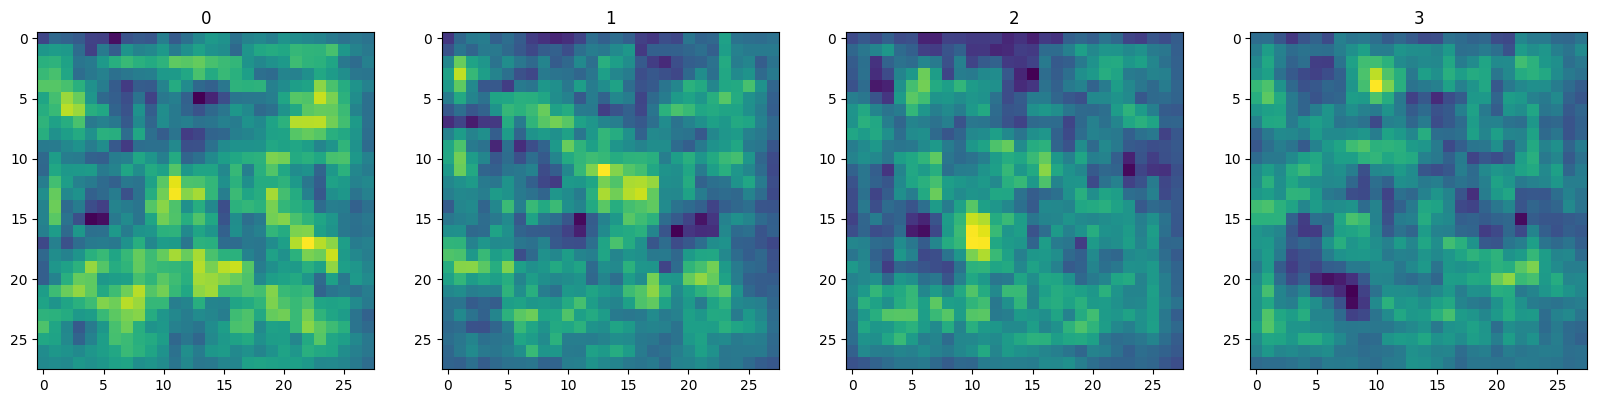

In [21]:
# Generate new fashion
img = generator.predict(np.random.randn(4,128,1))

# Setup the subplot formatting
fig,ax = plt.subplots(ncols=4,figsize=(20,20))
# Loop four times and get images
for idx,img in enumerate(img):
  # Plot the image using a specific subplot
  ax[idx].imshow(np.squeeze(img))
  # Appending the image label as plot title
  ax[idx].title.set_text(idx)

### 3.3 Build Discriminator

In [22]:
def build_discriminator():
  model = Sequential()

  #First Conv Block
  model.add(Conv2D(32,5, input_shape = (28,28,1)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  #Second Conv Block
  model.add(Conv2D(64,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  #Third Conv Block
  model.add(Conv2D(128,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  #Fourth Conv Block
  model.add(Conv2D(256,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  #Flatten and pass to Dense Layer
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation = 'sigmoid'))


  return model

In [23]:
discrimator = build_discriminator()
discrimator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [24]:
img.shape

(28, 28, 1)

In [25]:
discrimator.predict(np.expand_dims(img,0))

1/1 [==============================] - 0s 190ms/step


array([[0.500646]], dtype=float32)

# 4. Construct Training Loop

### 4.1 Setup Losses and Optimizers

In [26]:
# Adam is the optimizer used for Generator and Discriminator
from tensorflow.keras.optimizers import Adam
# Binary Cross Entropy is going to be the loss for Generator and Discriminator
from tensorflow.keras.losses import BinaryCrossentropy

In [27]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

### 4.2 Build Subclassed Model

In [28]:
# Importing the base model class to subclass our training step
from tensorflow.keras.models import Model

In [29]:
tf.random.normal((6,128,1))

<tf.Tensor: shape=(6, 128, 1), dtype=float32, numpy=
array([[[-1.66723359e+00],
        [ 3.26007158e-02],
        [-2.23161745e+00],
        [-1.82500273e-01],
        [-1.23751378e+00],
        [-1.36074972e+00],
        [ 3.41034979e-01],
        [ 9.41987693e-01],
        [ 3.46261740e-01],
        [-5.93046546e-01],
        [-4.39713687e-01],
        [ 9.47404325e-01],
        [ 1.29264247e+00],
        [ 8.65551382e-02],
        [-2.02584460e-01],
        [-1.17922258e+00],
        [ 8.16217840e-01],
        [ 6.23978615e-01],
        [-5.74930787e-01],
        [ 9.93925452e-01],
        [-1.59885490e+00],
        [ 1.07120407e+00],
        [-9.71090674e-01],
        [-4.77314353e-01],
        [-1.36847615e+00],
        [ 7.00486526e-02],
        [-1.97258198e+00],
        [ 1.13854444e+00],
        [-8.57292533e-01],
        [ 1.66510448e-01],
        [ 1.57017767e+00],
        [-4.79563236e-01],
        [ 2.93568701e-01],
        [ 4.98227596e-01],
        [ 1.05328751e+00],
  

In [30]:
tf.concat([tf.zeros_like(tf.random.normal((6,128))), tf.ones_like(tf.random.normal((6,128)))], axis =0)

<tf.Tensor: shape=(12, 128), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)>

In [31]:
class FashionGAN(Model):
  def __init__(self,generator , discrimator , *args, **kwargs):
    # Pass through args and kwargs to base class
    super().__init__(*args , **kwargs)

    # Create attributes for generator and discriminator
    self.generator = generator
    self.discrimator = discrimator

  def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
    # Compile with base class
    super().compile(* args, ** kwargs)

    # Create attributes for losses and optimizers
    self.g_opt = g_opt
    self.d_opt = d_opt
    self.g_loss = g_loss
    self.d_loss = d_loss


  def train_step(self, batch):
    # Get the data
    real_images = batch
    fake_images = self.generator(tf.random.normal((128,128,1)),training = False)

    # Train the discrimator
    with tf.GradientTape() as d_tape:
      # Pass the real and fake images to the discrimator model
      yhat_real = self.discrimator(real_images , training =True)
      yhat_fake = self.discrimator(fake_images , training= True)
      yhat_realfake = tf.concat([yhat_real, yhat_fake], axis =0)

      # Create labels for real and fake images
      y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis =0)

      # Add some noise to the outputs
      noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
      noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
      y_realfake += tf.concat([noise_real , noise_fake], axis =0)

      # Calculate loss
      total_d_loss = self.d_loss(y_realfake,yhat_realfake)


    # Apply backpropagation -  nn Learn
    dgrad = d_tape.gradient(total_d_loss , self.discrimator.trainable_variables)
    self.d_opt.apply_gradients(zip(dgrad, self.discrimator.trainable_variables))

    # Train the Generator
    with tf.GradientTape() as g_tape:
      # Generate new images
      gen_images = self.generator(tf.random.normal((128,128,1)), training =True)

      # Create the predicted labels
      predicted_labels = self.discrimator(gen_images , training=False)

      # Calculate the loss - trick to training to fake out the discriminator
      total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

    # Apply backprop
    ggrad= g_tape.gradient(total_g_loss, self.generator.trainable_variables)
    self.g_opt.apply_gradients(zip(ggrad,self.generator.trainable_variables))


    return {"d_loss":total_d_loss , "g_loss":total_g_loss}

In [32]:
# Create instance of subclass model
fashgan = FashionGAN(generator, discrimator)

In [33]:
#Compile the model
fashgan.compile(g_opt, d_opt , g_loss , d_loss)

### 4.3 Build Callback

In [34]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [35]:
class ModelMonitor(Callback):
    def __init__(self, num_img=2, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

### 4.4 Train

In [36]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

In [37]:
hist = fashgan.fit(ds, epochs = 10 , callbacks = [ModelMonitor()])

Epoch 1/10
469/469 [==============================] - 90s 170ms/step - d_loss: 0.5065 - g_loss: 1.0505
Epoch 2/10
469/469 [==============================] - 79s 167ms/step - d_loss: 0.6805 - g_loss: 0.7269
Epoch 3/10
469/469 [==============================] - 78s 167ms/step - d_loss: 0.6580 - g_loss: 0.6018
Epoch 4/10
469/469 [==============================] - 78s 167ms/step - d_loss: 0.6239 - g_loss: 0.2902
Epoch 5/10
469/469 [==============================] - 79s 168ms/step - d_loss: 0.7138 - g_loss: 0.4809
Epoch 6/10
469/469 [==============================] - 79s 168ms/step - d_loss: 0.6931 - g_loss: 0.5685
Epoch 7/10
469/469 [==============================] - 79s 168ms/step - d_loss: 0.6771 - g_loss: 0.5956
Epoch 8/10
469/469 [==============================] - 79s 168ms/step - d_loss: 0.6869 - g_loss: 0.6002
Epoch 9/10
469/469 [==============================] - 79s 168ms/step - d_loss: 0.5657 - g_loss: 0.4346
Epoch 10/10
469/469 [==============================] - 79s 168ms/step - d

### 4.5 Review Performance

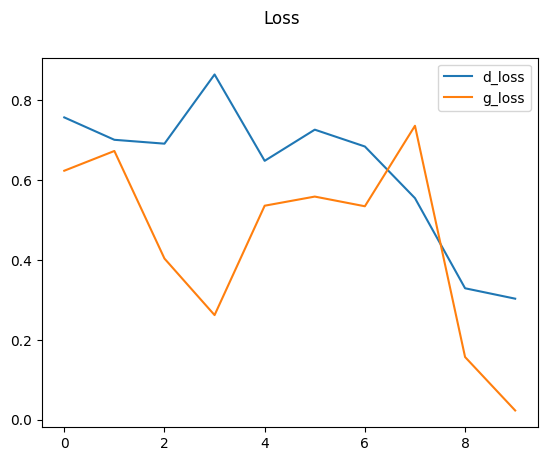

In [38]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

# 5. Test Out the Generator

### 5.1 Generate Images

In [40]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

1/1 [==============================] - 0s 361ms/step


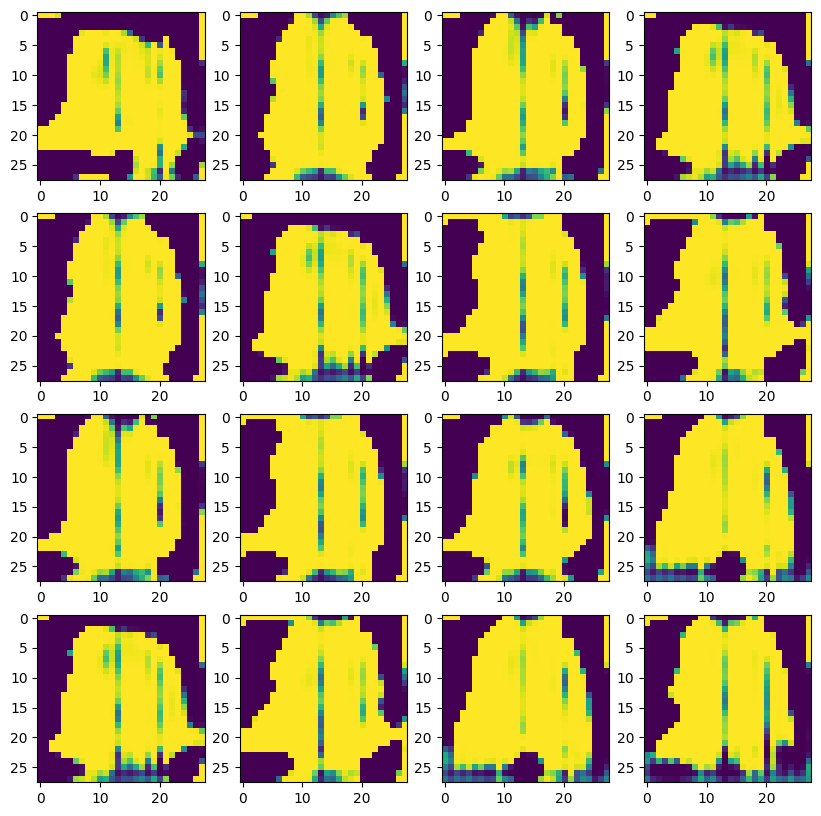

In [41]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

### 5.2 Save the Model

In [43]:
generator.save('generator.h5')
discrimator.save('discriminator.h5')